In [64]:
from netCDF4 import Dataset
import colorcet as cc
import cmocean.cm as cmo
import numpy as np
import salem
import xarray as xr
from matplotlib.cm import get_cmap

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wrf

In [65]:
p = 101300
def calc_q(RH, T2M, p):
     t2 = T2M - 273.13
     exponent = 7.5 * t2/(t2 - 237.3)#
     e = (RH/100) * 610.7 * 10**exponent
     q = ((0.622 * e) / p) * 1000
     return q

# P = 1013.25
# def calc_q(T, RH, P):
#     # Calculate saturation vapor pressure (e_s) in hPa
#     e_s = 6.112 **((17.67 * T) / (T + 243.5))
#     # Calculate actual vapor pressure (e) in hPa
#     e = (RH / 100.0) * e_s
#     # Calculate specific humidity (q) in g/kg
#     q = 622 * e / (P - 0.378 * e)
#     return q

In [66]:
wur_file = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_1h/wrfout_test')
wur_lcz_file = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz_1h/wrfout_test')

wur_file

<xarray.Dataset> Size: 10GB
Dimensions:                (south_north: 165, west_east: 220, time: 45,
                            bottom_top: 60, soil_layers: 3, seed_dim: 7)
Coordinates:
    lat                    (south_north, west_east) float32 145kB 52.29 ... 5...
    lon                    (south_north, west_east) float32 145kB 4.728 ... 5...
    xtime                  (time) datetime64[ns] 360B ...
  * time                   (time) datetime64[ns] 360B 2019-07-23T06:00:00 ......
  * west_east              (west_east) float64 2kB -8.411e+04 ... -6.221e+04
  * south_north            (south_north) float64 1kB 3.535e+04 ... 5.175e+04
Dimensions without coordinates: bottom_top, soil_layers, seed_dim
Data variables: (12/211)
    LU_INDEX               (time, south_north, west_east) float32 7MB ...
    ZNU                    (time, bottom_top) float32 11kB ...
    ZNW                    (time, bottom_top) float32 11kB ...
    ZS                     (time, soil_layers) float32 540B ...
    DZS                    (time, soil_layers) float32 540B ...
    VAR_SSO                (time, south_north, west_east) float32 7MB ...
    ...                     ...
    PRESSURE               (time, bottom_top, south_north, west_east) float32 392MB ...
    GEOPOTENTIAL           (time, bottom_top, south_north, west_east) float32 392MB ...
    Z                      (time, bottom_top, south_north, west_east) float32 392MB ...
    SLP                    (time, south_north, west_east) float32 7MB ...
    PRCP_NC                (time, south_north, west_east) float32 7MB ...
    PRCP_C                 (time, south_north, west_east) float32 7MB ...
Attributes: (12/137)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2019-07-23_06:00:00
    SIMULATION_START_DATE:           2019-07-23_06:00:00
    WEST-EAST_GRID_DIMENSION:        221
    SOUTH-NORTH_GRID_DIMENSION:      166
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    pyproj_srs:                      +proj=lcc +lat_0=51.9647178649902 +lon_0...

In [67]:
wur_q2 = wur_file.Q2.isel(time=34)
wur_t2 = wur_file.T2.isel(time=34)
wur_psfc = wur_file.PSFC.isel(time=34)

wur_rh = wrf.rh(wur_q2, wur_psfc, wur_t2)
wur_rh

<xarray.DataArray 'rh' (south_north: 165, west_east: 220)> Size: 145kB
array([[51.23159 , 51.004417, 50.952915, ..., 50.093193, 50.067413,
        50.035236],
       [47.719738, 50.855854, 50.807667, ..., 50.074966, 50.03387 ,
        49.97904 ],
       [47.512615, 47.450054, 50.546173, ..., 50.02    , 49.962086,
        49.88859 ],
       ...,
       [58.967693, 54.94449 , 58.905285, ..., 54.777042, 72.64353 ,
        54.55892 ],
       [58.830452, 58.84559 , 58.784748, ..., 54.14427 , 72.40389 ,
        72.33659 ],
       [58.646835, 58.68233 , 58.641956, ..., 72.21152 , 72.14274 ,
        72.0755  ]], dtype=float32)
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  relative humidity

In [68]:
wur_lcz_q2 = wur_lcz_file.Q2.isel(time=34)
wur_lcz_t2 = wur_lcz_file.T2.isel(time=34)
wur_lcz_psfc = wur_lcz_file.PSFC.isel(time=34)

wur_lcz_rh = wrf.rh(wur_lcz_q2, wur_lcz_psfc, wur_lcz_t2)
wur_lcz_rh

<xarray.DataArray 'rh' (south_north: 165, west_east: 220)> Size: 145kB
array([[51.298847, 50.72477 , 50.846725, ..., 49.803745, 49.84521 ,
        49.895092],
       [51.050343, 50.63627 , 50.461067, ..., 48.265476, 49.7619  ,
        49.780075],
       [47.35942 , 47.066116, 49.918163, ..., 49.677853, 49.64644 ,
        48.126717],
       ...,
       [55.8793  , 55.813572, 55.739292, ..., 49.976475, 51.709396,
        51.61198 ],
       [57.202286, 57.17373 , 57.146427, ..., 51.33573 , 51.20135 ,
        51.10273 ],
       [57.19589 , 57.186275, 57.181572, ..., 71.44294 , 71.37321 ,
        71.30957 ]], dtype=float32)
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  relative humidity

In [69]:
wur_q = calc_q(wur_rh, wur_t2, P)
lcz_q = calc_q(wur_lcz_rh, wur_lcz_t2, P)

lcz_q

<xarray.DataArray (south_north: 165, west_east: 220)> Size: 145kB
array([[16.135101, 15.851926, 15.893923, ..., 13.577725, 13.601688,
        13.628701],
       [16.034988, 15.791101, 15.727637, ..., 12.53788 , 13.601094,
        13.609946],
       [14.395507, 14.250378, 15.440347, ..., 13.594088, 13.575648,
        12.497576],
       ...,
       [20.159855, 20.109863, 20.050621, ..., 14.211385, 15.091308,
        15.074739],
       [21.047747, 21.016088, 20.983969, ..., 14.855954, 14.805787,
        14.784887],
       [20.97555 , 20.955177, 20.937164, ..., 34.787582, 34.74418 ,
        34.708286]], dtype=float32)
Coordinates:
  * west_east    (west_east) float64 2kB -8.411e+04 -8.401e+04 ... -6.221e+04
  * south_north  (south_north) float64 1kB 3.535e+04 3.545e+04 ... 5.175e+04
    lat          (south_north, west_east) float32 145kB 52.29 52.29 ... 52.44
    lon          (south_north, west_east) float32 145kB 4.728 4.73 ... 5.056
    xtime        datetime64[ns] 8B 2019-07-24T16:00:00
    time         datetime64[ns] 8B 2019-07-24T16:00:00

In [70]:
ax_options = {
    'color': 'black',
    'linestyle': 'dotted',
    'linewidth': 0.5,
    'zorder': 103,
    'draw_labels': True,
    'x_inline': False,
    'y_inline': False,
}
title_options = {
    'loc': 'left',
    'fontsize': 'x-large',
    'fontweight': 'bold',
}
proj = ccrs.PlateCarree()
extent = [wur_q2.lon.min(),wur_q2.lon.max(),wur_q2.lat.min(),wur_q2.lat.max()]

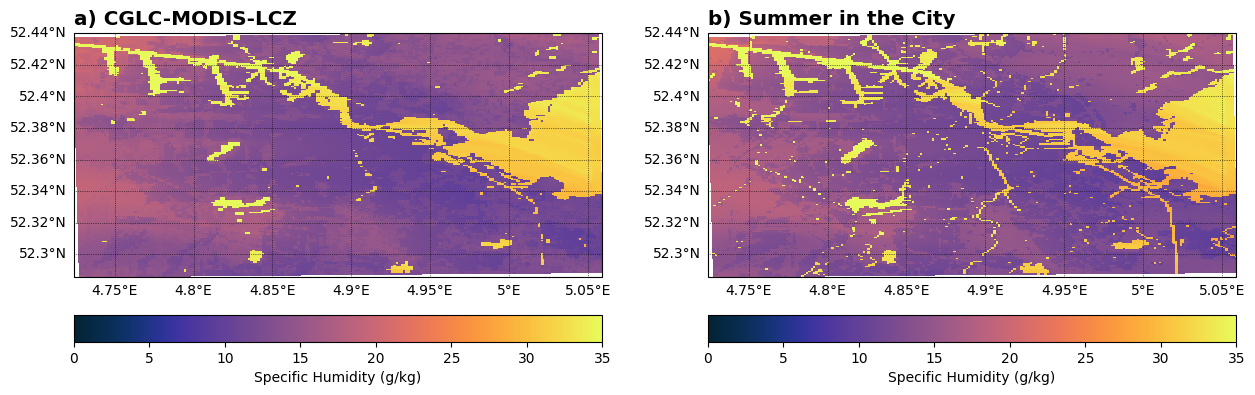

In [77]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent)
ct1 = ax1.pcolormesh(
    wur_t2.lon, wur_t2.lat, lcz_q, vmin=0, vmax=35, cmap=cmo.thermal, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax1.set_title('a) CGLC-MODIS-LCZ', **title_options)
cbar = fig.colorbar(ct1, orientation='horizontal', fraction=0.09, pad=0.1, label='Specific Humidity (g/kg)', ax=ax1)

ax2 = fig.add_subplot(1, 2, 2, projection=proj)
gl2 = ax2.gridlines(**ax_options)
gl2.right_labels = False
gl2.top_labels = False
ax2.set_extent(extent)
ct2 = ax2.pcolormesh(
    wur_t2.lon, wur_t2.lat, wur_q, vmin=0, vmax=35, cmap=cmo.thermal, transform=ccrs.PlateCarree()
)
ax2.coastlines(linewidth=1.0, resolution='10m')
ax2.set_title('b) Summer in the City', **title_options)
cbar = fig.colorbar(ct2, orientation='horizontal', fraction=0.09, pad=0.1, label='Specific Humidity (g/kg)', ax=ax2)

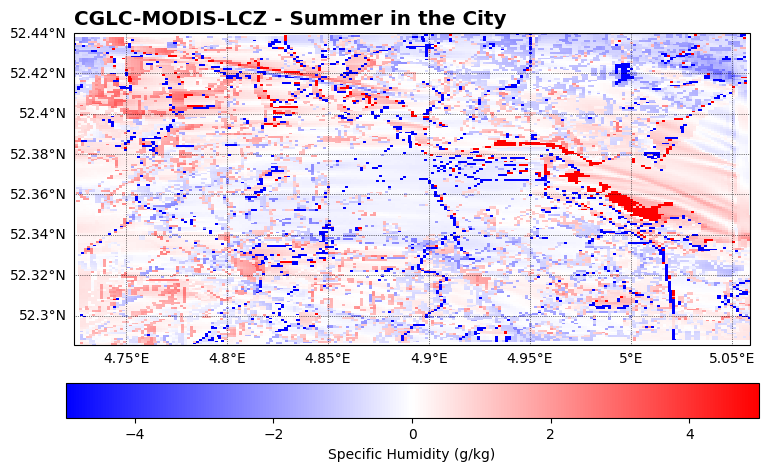

In [79]:
diff = lcz_q - wur_q

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent)
ct1 = ax1.pcolormesh(
    wur_t2.lon, wur_t2.lat, diff, vmin=-5, vmax=5, cmap='bwr', transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax1.set_title('CGLC-MODIS-LCZ - Summer in the City', **title_options)
cbar = fig.colorbar(ct1, orientation='horizontal', fraction=0.09, pad=0.1, label='Specific Humidity (g/kg)', ax=ax1)
